## Methodology
The process for conducting our research and modeling will follow the iterative OSEMiN pipeline. This entails obtaining, scrubbing, exploring, modeling, and interpreting the data. 

## Obtaining the Data

Importing the data and any modules needed to understand it

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from collections import Counter
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from scipy import stats
from math import log 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import xgboost as xgb 
from sklearn import svm
from sklearn.svm import SVC
import statsmodels as sm
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance

plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#open dataset
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')
df

In [ ]:
#getting data info 
df.info()

## Scrubbing the Data
- Manage datatypes
- Resolve missing/duplicate values.

In [ ]:
#checking null values
df.isnull().sum()

In [ ]:
#dropping duplicate rows 
df.drop_duplicates()

In [ ]:
# Check out spread of data and outliers
df.describe()

## Exploring the Data
- Find patterns among the relationships of variables in the dataset.  

#### Exploring the Target variable: 'Churn'

From the countplot below we can see that our target varibale is imablanced, this means that we will need to use SMOTE later. 

In [ ]:
# Check balance of target data 
sns.countplot(x='churn', data=df);
df['churn'].value_counts()

In [ ]:
# Check for nonsensical or placeholder values
# We can see that DC is included at the 51st State
for col in df.columns:
    print(col)
    print(df[col].unique())
    print('\n-----------------------------------------------\n')


In [ ]:
df.info()

In [ ]:
#checking variable correlations 
corr = df.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations', fontsize=40, y=.95, fontname='DejaVu Sans')
heatmap = sns.heatmap(corr, cmap='Blues', annot=True)

From this correlation map we can see that the charge columns are highly multicollinear with the minutes column. 

In [ ]:
#use seaborn pairplot
#code is commented out to save time.  Pairplot will take a few minutes to run


#### Dropping unneccasary columns

For this project we are focused on the services and prices SyriaTel provides on the national level, so individual phone numbers and area codes are not necessary in this case. We also dropped the charge columns because they were multicollinear and added unnecessary noise to our dataset. 

In [ ]:
#removing white space from column names 
df.columns = df.columns.str.replace(' ', '_')
#dropping charge columns 
df = df.drop([x for x in df.columns if x.endswith('_charge')],axis=1)
#dropping phone number because it is basically a Unique ID which we do not need for this data set 
df.drop('phone_number', axis=1, inplace=True)
df.drop('area_code', axis=1, inplace=True)
df.head()

#### Converting categorical data

- state
- international_plan 
- voice_mail_plan 
- churns  

We need to convert these so that we may intepret the data. 

In [ ]:
#one hot encoding 
origin = df['state']
origin_series = pd.Series(origin)
df['state'] = origin_series.astype('category')
df['state'] = df['state'].cat.codes
df.head()

In [ ]:
#Converting international_plan, voice_mail_plan, and churn to be 1 or 0 
#1= yes/true 0= no/false
df['international_plan'] = df['international_plan'].map(lambda x:1 if x == 'yes' else 0)
df['voice_mail_plan'] = df['voice_mail_plan'].map(lambda x:1 if x == 'yes' else 0)
df['churn'] = df['churn'].map(lambda x:1 if x == True else 0)

df

#### Define X and y

- Target variable (y): 'churn'
- Features (X): all othre columns

In [ ]:
#Defining churn as our target (y)
#Defining the rest of the columns as our features (X)
y = df['churn']
X = df.drop(columns='churn', axis=1)

In [ ]:
df.info()

#### Train Test Split 

In [ ]:
#setting up our train/test split
#stratifying the data due to the large imablance in target classes 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=56, stratify=y)
# Check size of train and test sets
print(len(X_train), len(X_test), len(y_train), len(y_test))

## Modeling the Data
- Create baseline model 
- Iterate through different models 

In [ ]:
class Model_test():
    
    '''
    This class will be used to quickly test and save models for comparison
    This class was modified from lecture: Classifican Workflow - Flatiron School - Greg Damico
    
    '''
    
    def __init__(self, mod_name, model, X, y, run_cv=True):
        self.name = mod_name
        self.model = model
        self.X = X
        self.y = y
        #cross validation
        self.cv_result = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        
        if run_cv:
            self.cross_val()
        
    def cross_val(self, X=None, y=None, kfolds=5):
        '''
        Perform cross validation on the model.
        '''
        #checks to see if user entered other values for X,y
        cv_X = X if X else self.X 
        cv_y = y if y else self.y
        
        self.cv_results = cross_val_score(self.model,cv_X,cv_y,cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_std = np.std(self.cv_results)
        self.cv_median = np.median(self.cv_results)
    
        
    #display overall summary
    def print_summary(self):
        res_mean = round(self.cv_mean,4)
        res_std = round(self.cv_std,4)
        print('CV Results for {}\n {} +- {} accuracy'.format(self.name,res_mean,res_std))
        
        #print precision, recall, f1
        y_preds = self.model.predict(self.X)
        prec = precision_score(self.y,y_preds,zero_division='warn')
        rec = recall_score(self.y,y_preds,zero_division='warn') 
        f1s = f1_score(self.y,y_preds,zero_division='warn')
        
        print('\n\nPrecision:{}\tRecall:{}\tF1_Score:{}'.format(prec,rec,f1s))
        
        #plot roc_curve
        print('\nROC CURVE')
        plot_roc_curve(self.model, self.X, self.y)
        plt.show()
        
        #plot confusion matrix
        print('\nCONFUSION MATRIX')
        plot_confusion_matrix(self.model,self.X, self.y,cmap='YlGnBu')
        plt.show()
   #returns the models recall score.  This is our chosen metric.      
    def model_recall(self):
        y_preds = self.model.predict(self.X)
        return recall_score(self.y,y_preds,zero_division='warn') 
        
        

### Baseline Dummy Model 
We are creating a dummy model to serve as our baseline. This dummy model will pick most dominant class in our, in this case 'no churn' which occurs 85% of the time. This means the dummy model should have 85% accuracy. 

In [ ]:
dm = DummyClassifier(strategy='most_frequent')
dm.fit(X_train, y_train)
dm_result = Model_test('Dummy Model', dm, X_train, y_train)
dm_result.print_summary()

The AUC-ROC curve for our baseline dummy model should be a diagnol line from 0.0 to 0.1, this is because our dummy model should be no better than a 50/50 guess. Any AUC-ROS curve above the baseline curve indicates that it is performing better than the baseline. 

In [ ]:
dm_result.model_recall()

In [ ]:
##create a dictionary to store results of tests
model_dict = {}
model_dict['baseline'] = dm_result.model_recall()
model_dict

#### Scaling the Data
The data is being standardized since the features in the dataset have different ranges. 

In [ ]:
#Instantiate StandardScaler
scaler = StandardScaler()

#Transform X_train to scaled data set and fit the model with scaled X train data
scaled_X_train = scaler.fit_transform(X_train)

#Transform X_test to scaled data set
scaled_X_test= scaler.transform(X_test)

#Convert scaled data into a DataFrame
scaled_X_train = pd.DataFrame(scaled_X_train,columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test,columns=X_test.columns)

#### SMOTENC - Synthetic Minority Over-sampling Technique for Nominal and Continuous
From the above data we can see that there is a class imbalance in our target variable, 'churn', so we will use SMOTENC to synthesize data to level out the imbalance. Currently, we are 85% no churn and 15% churn.  We are using SMOTENC due to have binary columns. 



In [ ]:
from imblearn.over_sampling import SMOTE,SMOTENC
# Create instance of smotec
smote = SMOTENC(categorical_features=[0, 1, 2, 3], random_state=56)

# Create resampled version of the train dataset
resampled_X_train, resampled_y_train = smote.fit_resample(scaled_X_train, y_train)


In [ ]:
#before smote
print('Before Smote\n', y_train.value_counts())

#after smote
print('\nAfter Smote\n', resampled_y_train.value_counts())

### Logistic Regression Model 

Now that we have our baseline model we can begin trying out different models. 

In [ ]:
lr= LogisticRegression(random_state = 56)
lr.fit(X_train,y_train)
lr_result = Model_test('Logistic Regression', lr, X_train, y_train)
lr_result.print_summary()

In [ ]:
model_dict['logistic regression'] = lr_result.model_recall()
model_dict

### Logistic Regression Model with resampled and standardized data

Let's run the logistic regression again on our resampled data. 

In [ ]:
lr.fit(resampled_X_train, resampled_y_train)
lr_result_b = Model_test('Logistic Regression', lr, resampled_X_train, resampled_y_train)
lr_result_b.print_summary()

In [ ]:
model_dict['logistic regression balanced'] = lr_result_b.model_recall()
model_dict

By standardizing the data and dealing with our class imbalance using SMOTEC we can see the recall score has jumped from 0.06 with an accuracy of 0.85 to a recall score of 0.83 and an accuracy of 0.73. 

## Decision Tree

In [ ]:
# Instantiate a DecisionTreeClassifier()
dt= DecisionTreeClassifier(max_depth=3, random_state=56)

In [ ]:
#running a decision tree on our imbalanced dataset
dt.fit(X_train, y_train)
dt_result= Model_test('Decision Tree', dt, X_train, y_train)
dt_result.print_summary()

In [ ]:
model_dict['decision tree'] = dt_result.model_recall()
model_dict

In [ ]:
#running a decision tree on our balanced dataset
dt.fit(resampled_X_train, resampled_y_train)
dt_result_b= Model_test('Decision Tree', dt, resampled_X_train, resampled_y_train)
dt_result_b.print_summary()

In [ ]:
model_dict['decision tree balanced'] = dt_result_b.model_recall()
model_dict

## Random Forest

While our decision tree results were good they are prone to overfitting the data. Using a random forest model should help. Random Forest models help with overfitting by creating many trees. The ensemble of trees prevents the model from overfitting. 

In [ ]:
rf = RandomForestClassifier(random_state =56)
#parameters for RandomForestClassifier
params={'min_samples_leaf':[1,5,10],
       'criterion':['gini','entropy'],
        'max_depth':[7,10,13]}
#create a GridSearchCV
gs=GridSearchCV(estimator=rf,param_grid=params,cv=10,scoring="recall")

In [ ]:
#running a Random Forest on our imbalanced dataset
gs.fit(X_train, y_train)
rf_result= Model_test('Random Forest', gs, X_train, y_train)
rf_result.print_summary()

In [ ]:
model_dict['random forest'] = rf_result.model_recall()
model_dict

In [ ]:
#running a random forest on our balanced dataset
gs.fit(resampled_X_train, resampled_y_train)
rf_result_b= Model_test('Random Forest', gs, resampled_X_train, resampled_y_train)
rf_result_b.print_summary()

In [ ]:
model_dict['random forest balanced'] = rf_result_b.model_recall()
model_dict

## XG Boost Model

In [104]:
from sklearn.model_selection import StratifiedKFold
xg = XGBClassifier(random_state =56)
#parameters for XGBClassified
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

#create a GridSearchCV
gs_xg=GridSearchCV(xg, param_grid, scoring='recall', cv=None, n_jobs=1)

CV Results for Random Forest
 0.6353 +- 0.0506 accuracy


Precision:0.13430127041742287	Recall:0.6132596685082873	F1_Score:0.22034739454094293

ROC CURVE


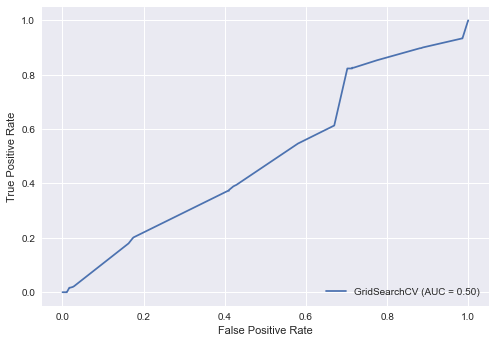


CONFUSION MATRIX


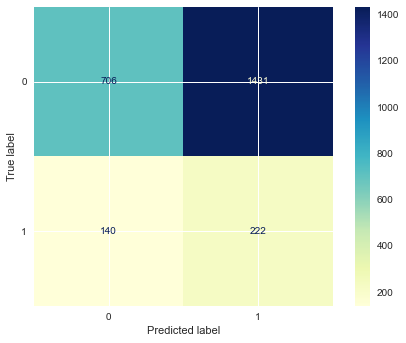

In [105]:
#running XG Boost Model on our imbalanced dataset
gs_xg.fit(X_train, y_train)
xg_result= Model_test('XG', gs_xg, X_train, y_train)
rf_result.print_summary()

In [106]:
model_dict['XG'] = xg_result.model_recall()
model_dict

{'baseline': 0.0,
 'logistic regression': 0.06629834254143646,
 'logistic regression balanced': 0.7810014038371549,
 'decision tree': 0.4116022099447514,
 'decision tree balanced': 0.8058025269068788,
 'random forest': 0.930939226519337,
 'random forest balanced': 0.9873654656059897,
 'XG': 0.9226519337016574,
 'XG balanced': 0.9995320542817033}

CV Results for XG balanced
 0.9462 +- 0.0664 accuracy


Precision:1.0	Recall:0.9995320542817033	F1_Score:0.9997659723847413

ROC CURVE


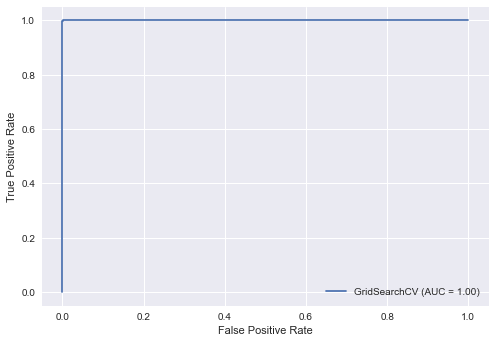


CONFUSION MATRIX


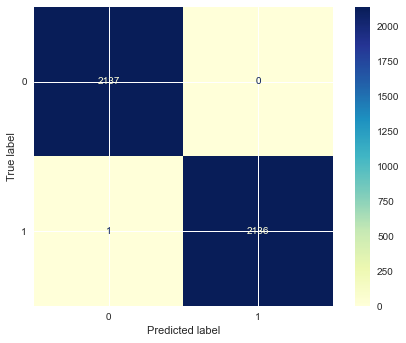

In [107]:
#running XG Boost on our resampled data 
gs_xg.fit(resampled_X_train, resampled_y_train)
xg_result_b= Model_test('XG balanced', gs_xg, resampled_X_train, resampled_y_train)
xg_result_b.print_summary()

In [108]:
model_dict['XG balanced'] = xg_result_b.model_recall()
model_dict

{'baseline': 0.0,
 'logistic regression': 0.06629834254143646,
 'logistic regression balanced': 0.7810014038371549,
 'decision tree': 0.4116022099447514,
 'decision tree balanced': 0.8058025269068788,
 'random forest': 0.930939226519337,
 'random forest balanced': 0.9873654656059897,
 'XG': 0.9226519337016574,
 'XG balanced': 0.9995320542817033}

### Model results:

As we can see from our model results our best performing model is our XG balanced model with a recall of 0.999 and our random forest balanced model with a recall of 0.987, 


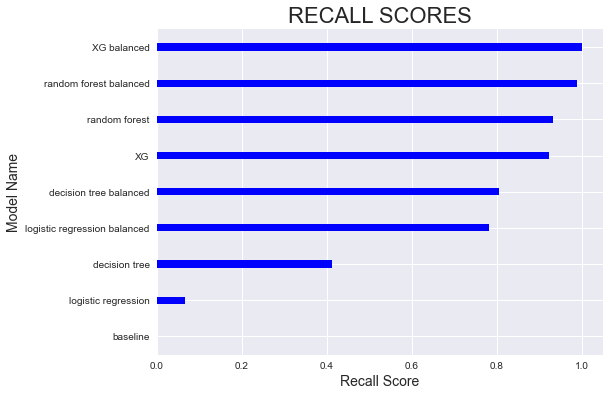

In [109]:
#sorting the recall results 
sorted_recall = sorted(model_dict.items(), key=lambda x:x[1])
sorted_model_dict = dict(sorted_recall)

#plot from model dict
values = sorted_model_dict.values()
models = [key for key in sorted_model_dict.keys()]
models

fig=plt.subplots(figsize=(8,6))
plt.barh(range(len(sorted_model_dict)), values, tick_label=models, color='blue', height=0.2)
plt.xlabel('Recall Score',fontsize =14)
plt.ylabel('Model Name', fontsize=14)
plt.title('RECALL SCORES', fontsize=22)
plt.show()


CV Results for Random Forest
 0.9162 +- 0.0327 accuracy


Precision:0.9981078524124882	Recall:0.9873654656059897	F1_Score:0.9927075982121853

ROC CURVE


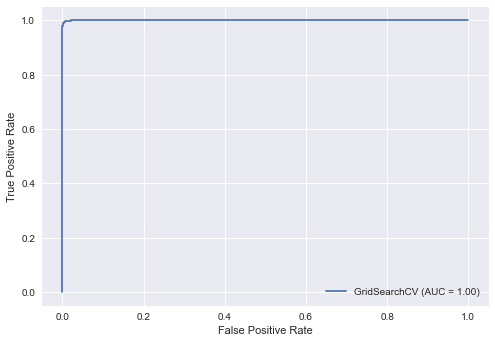


CONFUSION MATRIX


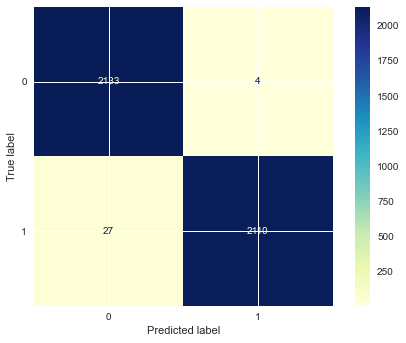

In [110]:
rf_result_b.print_summary()

Let's look at each model and compare how they performed. 

CV Results for XG balanced
 0.9462 +- 0.0664 accuracy


Precision:1.0	Recall:0.9995320542817033	F1_Score:0.9997659723847413

ROC CURVE


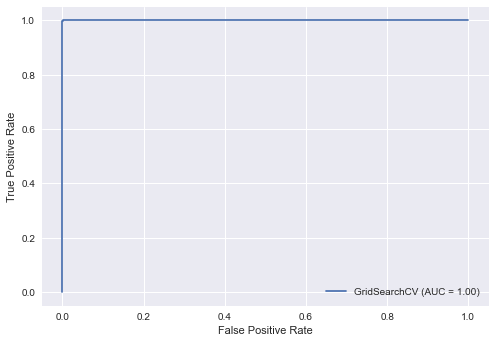


CONFUSION MATRIX


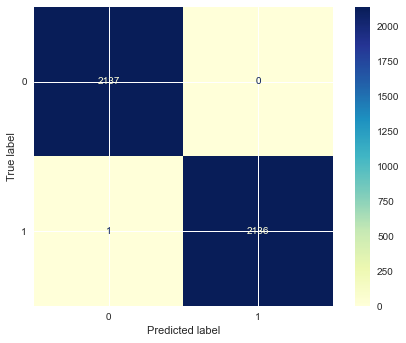

In [111]:
xg_result_b.print_summary()

### Final Model on Test Data

We will now use our final model of our hypertuned XG Boost model on our balanced dataset. 


In [ ]:
#running XG Boost on our resampled data test data
gs_xg.fit(resampled_X_test, resampled_y_test)
xg_result_b= Model_test('XG balanced', gs_xg, resampled_X_test, resampled_y_test)
xg_result_b.print_summary()

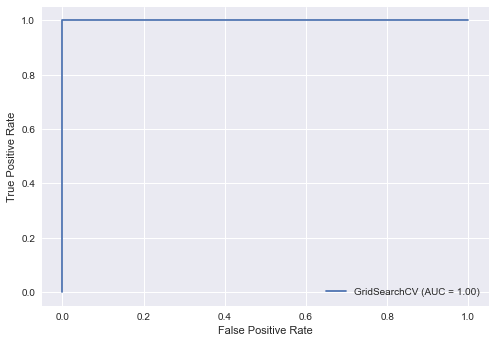

In [118]:
#auc_roc
plot_roc_curve(gs_xg, resampled_X_test, resampled_y_test)

In [122]:
print('Train Score:', gs_xg.score(resampled_X_train, resampled_y_train))
print('Test Score:', gs_xg.score(resampled_X_test, resampled_y_test))

Train Score: 0.7781937295273749
Test Score: 1.0


## Interpreting the Data
- Identify insights 
- Visualize findings

### Feature Importance on Decision Tree Model 

By using scikit learns feature importance we can see what variables most impacted customer churn rate. 

In [ ]:
#Using feature importance 
feature_importances = dt_grid.feature_importances_

# Create a list of features: done
feature_list = list(resampled_X_train.columns)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)


result = relative_importances.reset_index().sort_values('importance',ascending=False)

#plot feature importances with sorted values
sns.barplot(x='importance', y="index", data=result, color='blue');

The 3 most important features found were:
- total_day_minutes 
- customer_service_calls 
- total_intl_calls 